In [ ]:
! pip install -q kaggle
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                  title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows               Netflix Movies and TV Shows                           1MB  2024-04-10 09:48:38           3623         72  1.0              
sudarshan24byte/online-food-dataset                  Online Food Dataset                                   3KB  2024-03-02 18:50:30          30649        588  0.9411765        
nayanack/netflix                                     Netflix Chronicles: Exploring Movies and TV Shows     1MB  2024-04-16 07:36:08           1101         23  0.88235295       
mexwell/heart-dis

In [ ]:
 ! kaggle datasets download -d christofel04/cardiovascular-study-dataset-predict-heart-disea

cardiovascular-study-dataset-predict-heart-disea.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Extracting the compressed dataset.
from zipfile import ZipFile
data_path = '/content/cardiovascular-study-dataset-predict-heart-disea.zip'
with 	ZipFile(data_path, 'r') as zip : zip.extractall()

## ***Loading and Exploring Data***



 Première étape de notre projet d'analyse des maladies cardiaques, nous commençons par initialiser notre environnement Spark et importer les données à partir d'un fichier CSV.

In [ ]:
!pip install pyspark

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

In [ ]:
#Initialisation de l'environnement Spark et importation des données
spark = SparkSession.builder \
    .appName("Analyse de maladies cardiaques") \
    .getOrCreate()

# Lecture des données CSV
train_data = spark.read.format("csv") \
    .option("inferSchema", "true") \
    .option("header", "true") \
    .load("/content/train.csv").toPandas()
#visualisation des données qui permet de comprendre la structure et le contenu de nos données
train_data

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,3385,60,1.0,F,NO,0.0,0.0,0,0,0,261.0,123.5,79.0,29.28,70.0,103.0,0
3386,3386,46,1.0,F,NO,0.0,0.0,0,0,0,199.0,102.0,56.0,21.96,80.0,84.0,0
3387,3387,44,3.0,M,YES,3.0,0.0,0,1,0,352.0,164.0,119.0,28.92,73.0,72.0,1
3388,3388,60,1.0,M,NO,0.0,NaN,0,1,0,191.0,167.0,105.0,23.01,80.0,85.0,0


# ***Data Preparation***

In [ ]:
# On va créer une copie des données d'origine pour les préparer et les analyser sans altérer les données initiales.
df_copy=train_data.copy()

Gestion des valeurs manquates

In [ ]:
# Vérification des valeurs manquantes
# ici  nous utilisons une fonction pour afficher les colonnes contenant des valeurs manquantes, ainsi que le nombre et le pourcentage de ces valeurs manquantes.
def show_missing():
    missing = df_copy.columns[df_copy.isnull().any()].tolist()
    return missing

# Missing data counts and percentage
print('Missing Data Count')
print(df_copy[show_missing()].isnull().sum().sort_values(ascending = False))
print('--'*50)
print('Missing Data Percentage')
print(round(df_copy[show_missing()].isnull().sum().sort_values(ascending = False)/len(df_copy)*100,2))

Missing Data Count
glucose       304
education      87
BPMeds         44
totChol        38
cigsPerDay     22
BMI            14
heartRate       1
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
glucose       8.97
education     2.57
BPMeds        1.30
totChol       1.12
cigsPerDay    0.65
BMI           0.41
heartRate     0.03
dtype: float64


<Axes: >

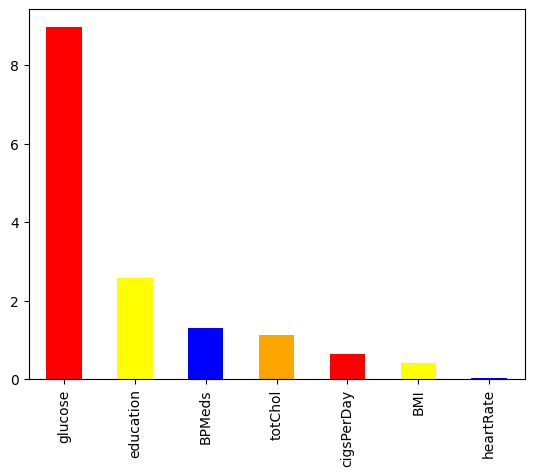

In [ ]:

#Ce graphique à barres montre le pourcentage de valeurs manquantes pour chaque colonne de données.
round(df_copy[show_missing()].isnull().sum().sort_values(ascending = False)/len(df_copy)*100,2).plot(kind='bar', color=['red', 'yellow', 'blue', 'orange'])

In [ ]:
#on  remplace les valeurs manquantes dans différentes colonnes de df_copy par  des valeurs de remplacement
#calculées à partir des données d'entraînement (train_data
df_copy['glucose']=df_copy['glucose'].fillna(train_data['glucose'].median())
df_copy['education']=df_copy['education'].fillna(train_data['education'].mode()[0])
df_copy['BPMeds']=df_copy['BPMeds'].fillna(train_data['BPMeds'].mode()[0])
df_copy['totChol']=df_copy['totChol'].fillna(train_data['totChol'].median())
df_copy['cigsPerDay']=df_copy['cigsPerDay'].fillna(train_data['cigsPerDay'].median())
df_copy['BMI']=df_copy['BMI'].fillna(train_data['BMI'].median())
df_copy['heartRate']=df_copy['heartRate'].fillna(train_data['heartRate'].median())

In [ ]:
# On affiche à nouveau le nombre de valeurs manquantes après le traitement pour vérifier si les valeurs manquantes ont été correctement traitées.
print('Nombre de données manquantes')
print(df_copy[show_missing()].isnull().sum().sort_values(ascending = False))
print('--'*50)


Nombre de données manquantes
Series([], dtype: float64)
----------------------------------------------------------------------------------------------------


In [ ]:
df_copy.isnull().sum()

id                 0
age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [ ]:
df_copy.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


***Conversion des valeurs catégorielles en valeurs numériques***

In [ ]:
# Importer pandas
import pandas as pd



# Remplacer les valeurs True et False par 1 et 0 dans les colonnes catégorielles
df_copy['sex'] = df_copy['sex'].replace({'F': 1, 'M': 0})
df_copy['is_smoking'] = df_copy['is_smoking'].replace({'YES': 1, 'NO': 0})

# Afficher les données modifiées
df_copy.head()


,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,1,1,3.0,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1
1,1,36,4.0,0,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,1,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,0,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,1,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


*** Suppression de  la colonne "id"***

In [ ]:
# Supprimer la colonne "id"
#Id is not useful for Model training.
df_copy.drop(columns=['id'], inplace=True)

# Afficher les données après la suppression de la colonne "id"
df_copy.head()


,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,2.0,1,1,3.0,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1
1,36,4.0,0,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,1,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,0,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,1,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


In [ ]:
#Nous allons supprimer l’attribut is_smoking, car l’attribut cigsPerDay contient des informations complètes et plus detailles sur le nombre de cigarette que la personne a fumé "#
df_copy.drop(columns=['is_smoking'], inplace=True)

df_copy.head()


,age,education,sex,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,2.0,1,3.0,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1
1,36,4.0,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,0,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0



***Visualisation de la distribution des variables explicatives par rapport à la variable cible 'TenYearCHD' à l'aide de graphiques de boîte***

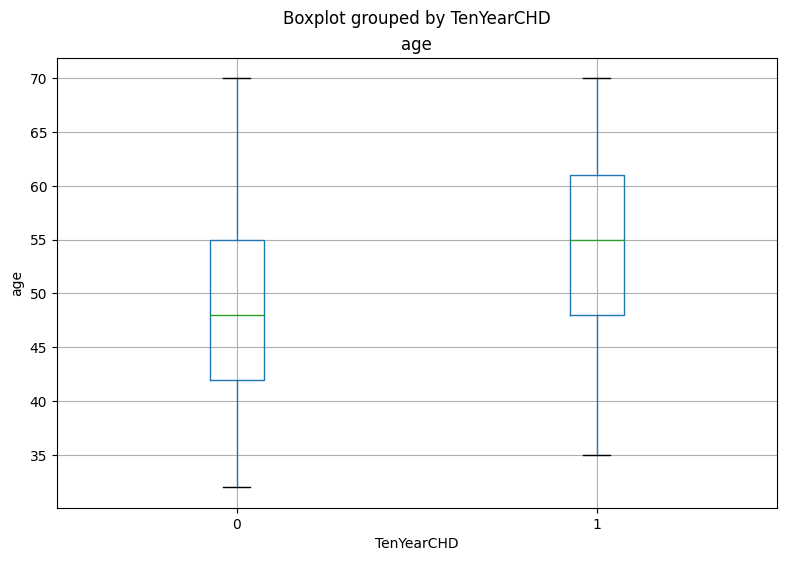

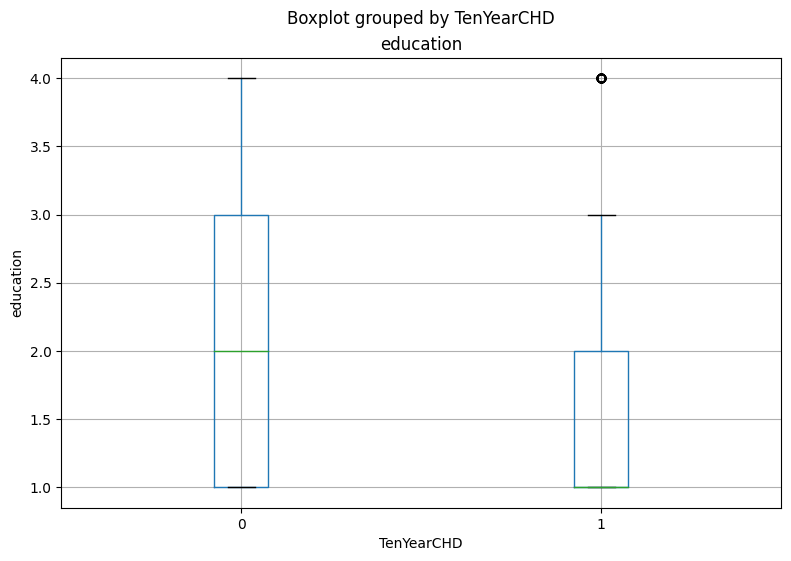

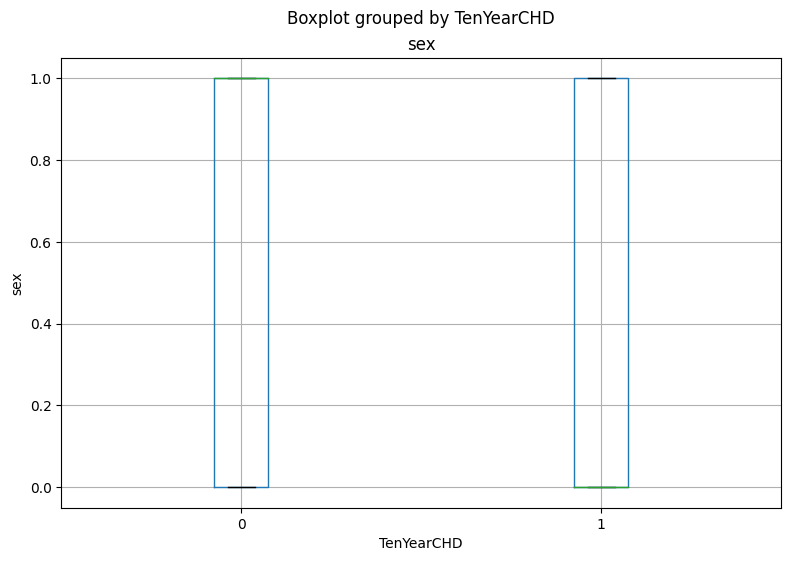

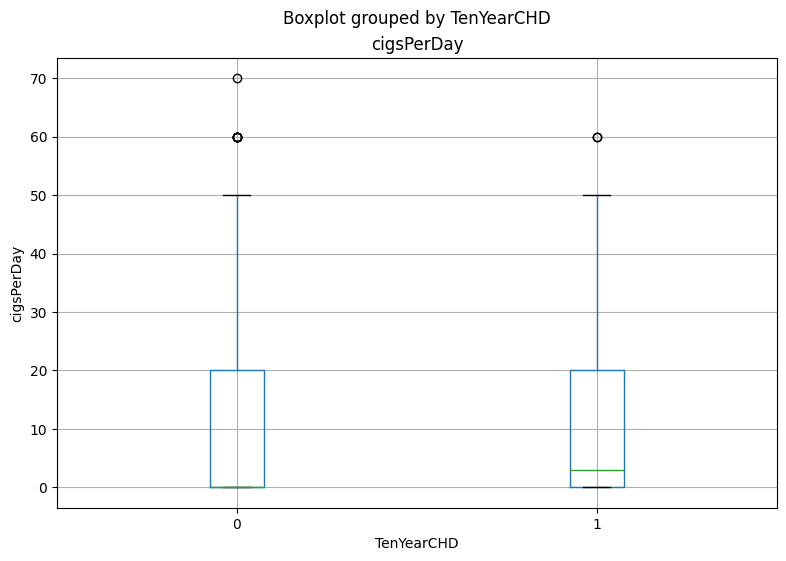

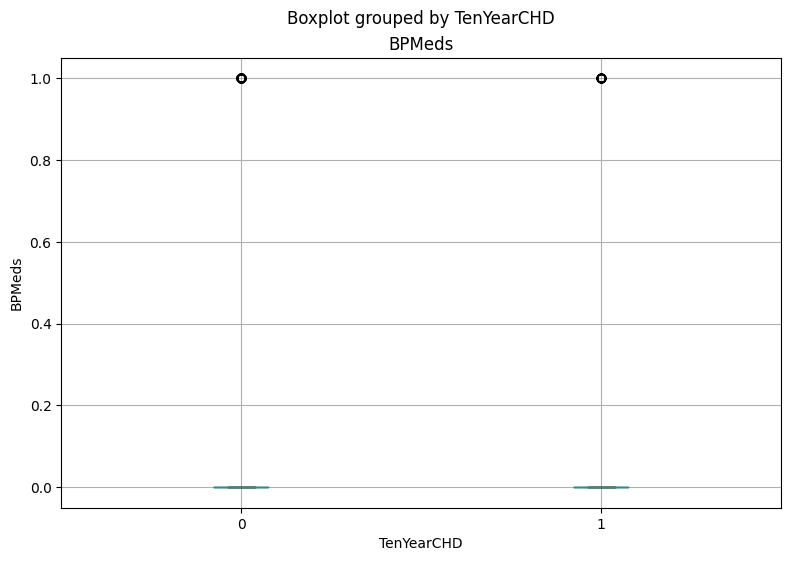

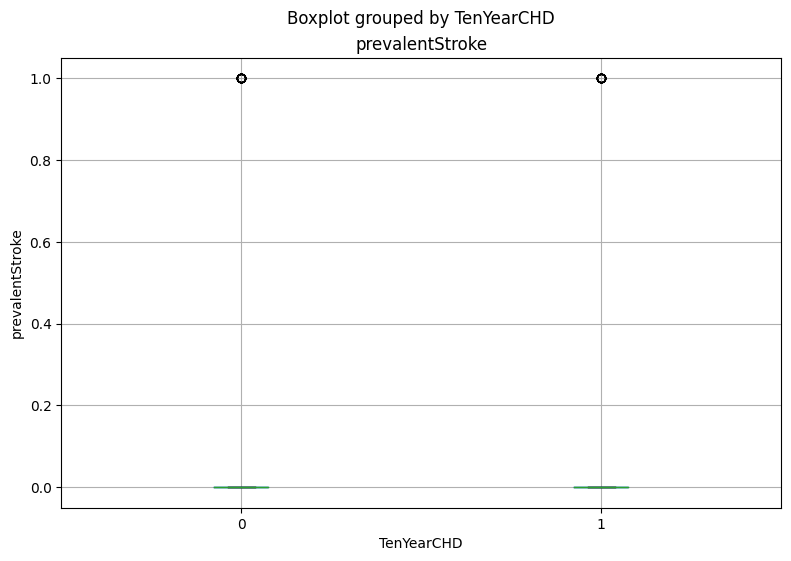

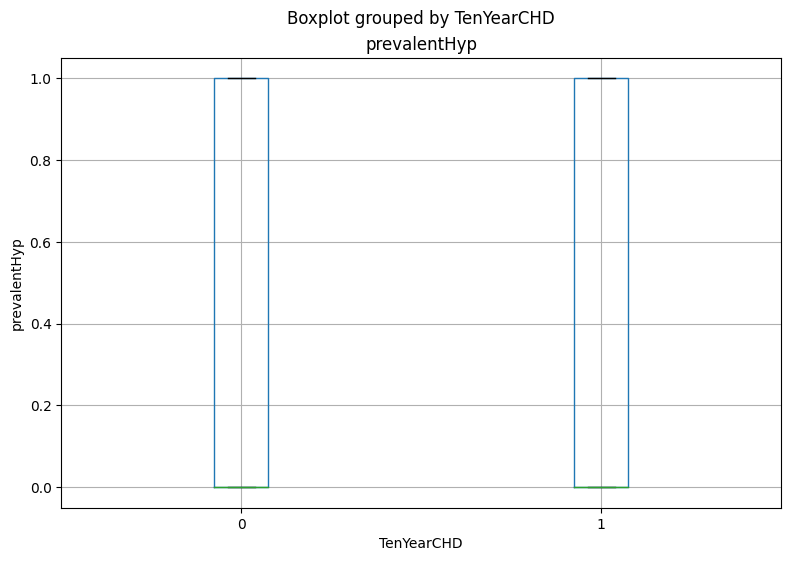

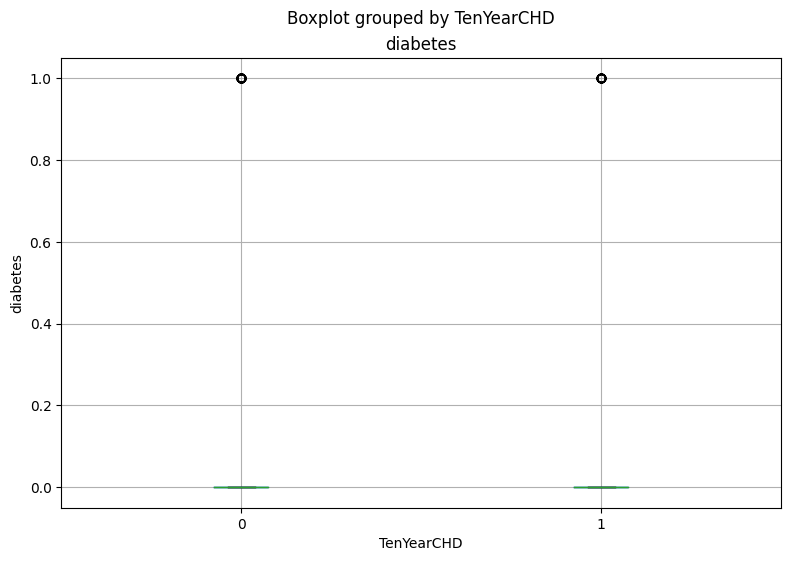

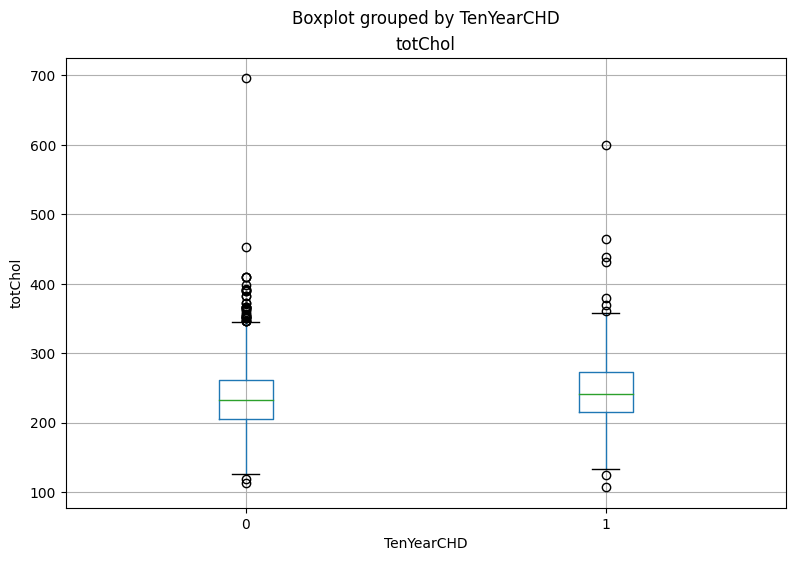

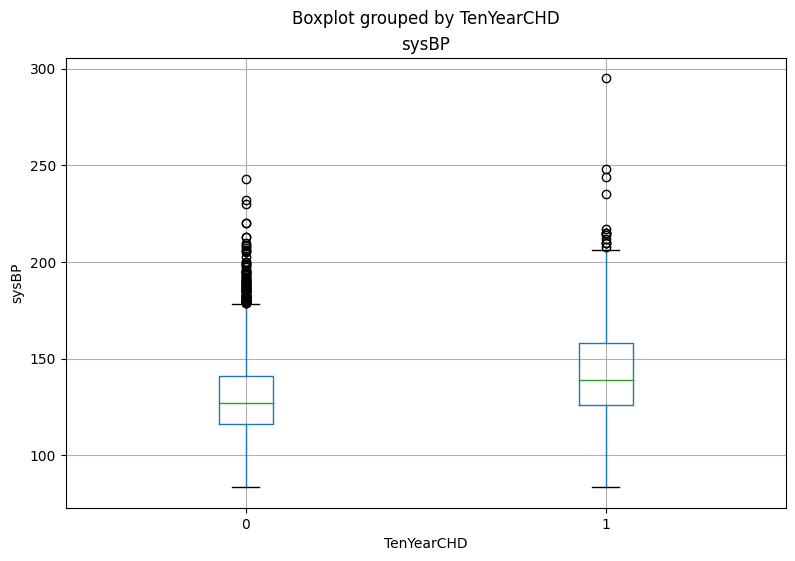

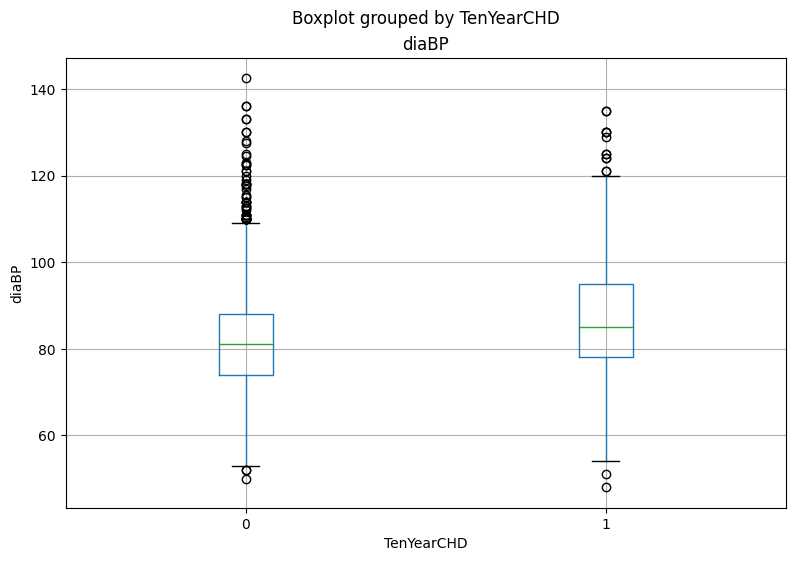

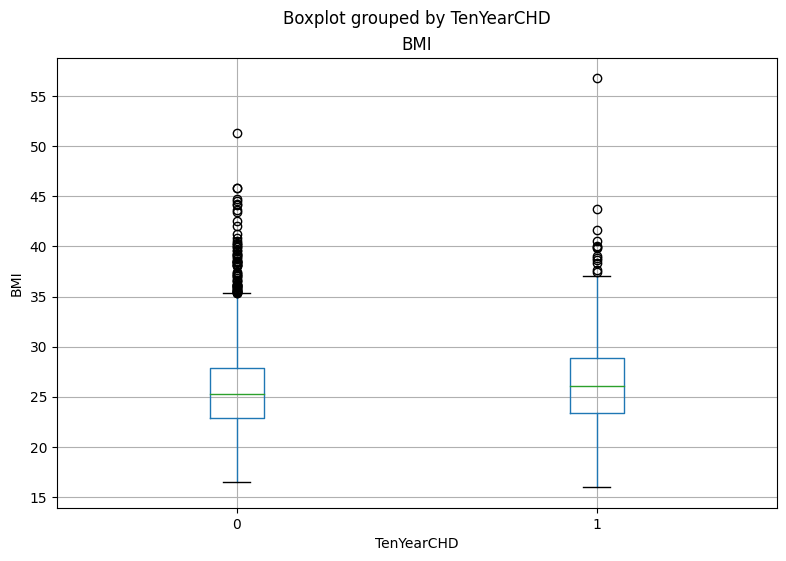

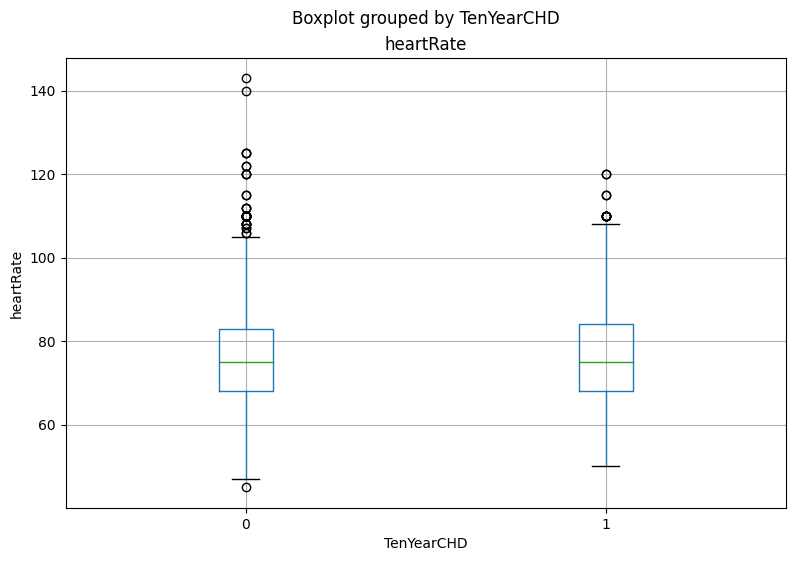

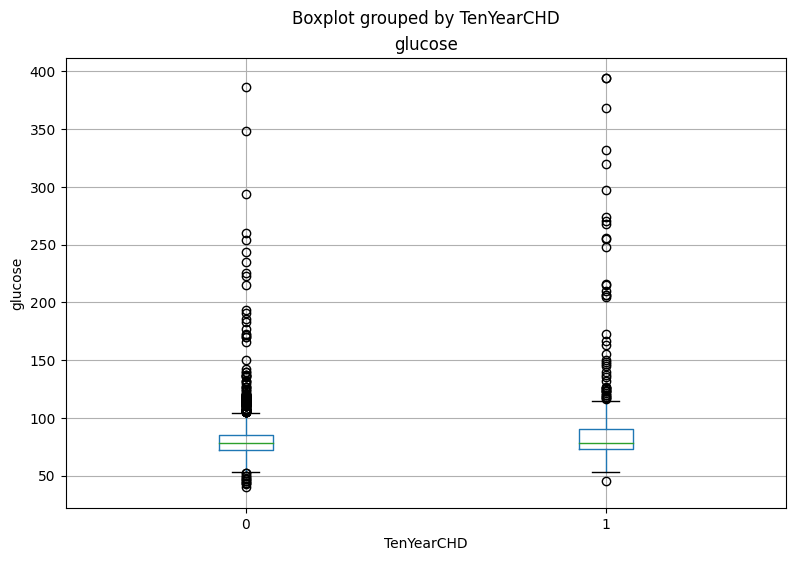

In [ ]:
for i in df_copy.columns[:-1]:
  fig = plt.figure(figsize=(9, 6))
  ax = fig.gca()
  df_copy.boxplot(column = i, by = 'TenYearCHD', ax = ax)
  ax.set_ylabel(i)
plt.show()

*** Identification et traitement  des valeurs aberrantes pour la variable "glucose"***

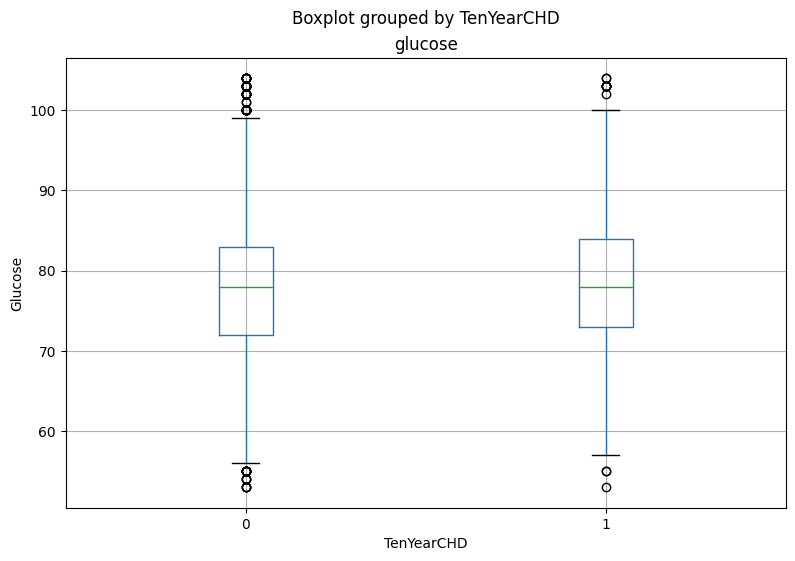

In [ ]:
# Identifier les valeurs aberrantes pour la variable "glucose"
Q1_glucose = df_copy['glucose'].quantile(0.25)
Q3_glucose = df_copy['glucose'].quantile(0.75)
IQR_glucose = Q3_glucose - Q1_glucose
lower_bound_glucose = Q1_glucose - 1.5 * IQR_glucose
upper_bound_glucose = Q3_glucose + 1.5 * IQR_glucose

# Remplacer les valeurs aberrantes par la médiane
median_glucose = df_copy['glucose'].median()
df_copy['glucose'] = df_copy['glucose'].apply(lambda x: median_glucose if x < lower_bound_glucose or x > upper_bound_glucose else x)

# Afficher les boxplots après le nettoyage des valeurs aberrantes de glucose
fig = plt.figure(figsize=(9, 6))
ax = fig.gca()
df_copy.boxplot(column='glucose', by='TenYearCHD', ax=ax)
ax.set_ylabel('Glucose')
plt.show()


 ***Correlation***

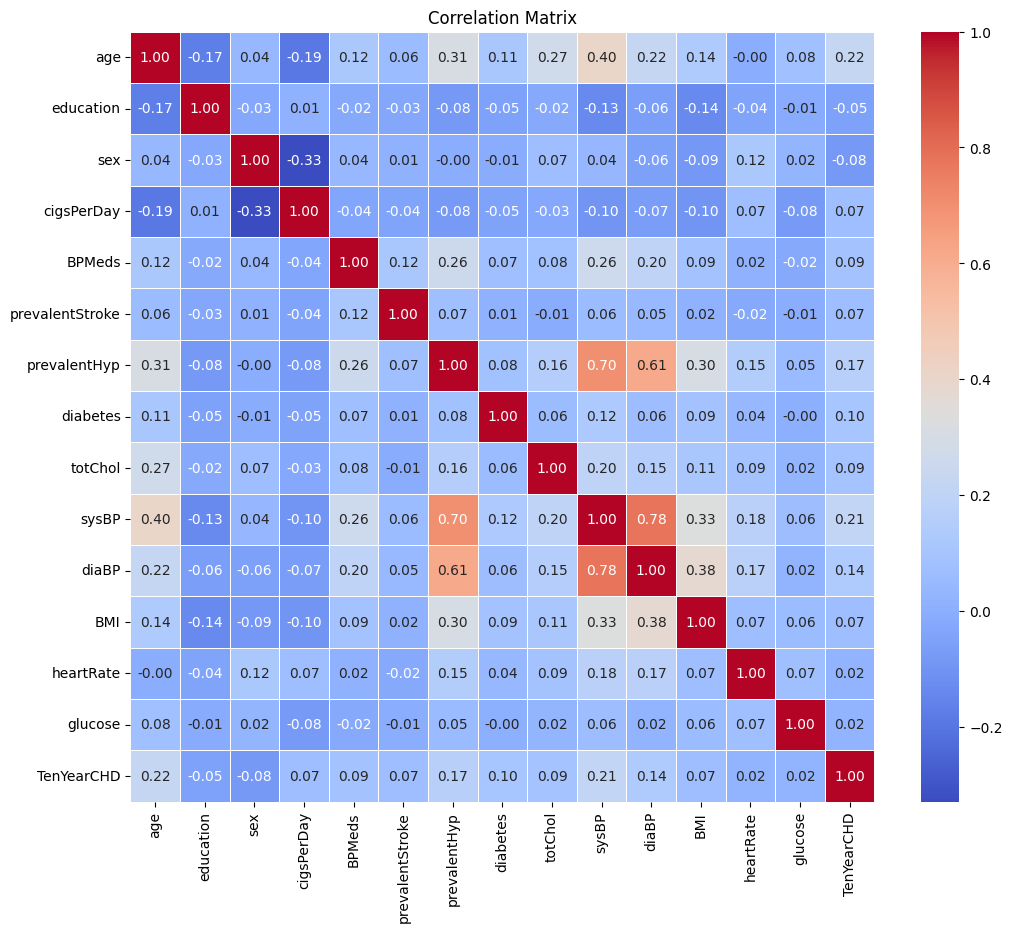

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Matrice de corrélation
correlation_matrix = df_copy.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


Il existe une forte dépendance linéaire entre la pression artérielle systolique et diastolique.

***Assemblage de Caractéristiques ***

 Ce code utilise VectorAssembler de PySpark pour regrouper les caractéristiques sélectionnées en un vecteur unique appelé "features". Ensuite on affiche les caractéristiques assemblées avec la variable cible.

In [ ]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ['age','sex','cigsPerDay','BPMeds','prevalentStroke','prevalentHyp','diabetes','totChol','sysBP','diaBP','BMI','heartRate','glucose'],outputCol='features')

df_spark = spark.createDataFrame(df_copy)

result = assembler.transform(df_spark)

Affichage des Caractéristiques Assemblées avec la Variable Cible

In [ ]:
result.select('features','TenYearCHD').show()

+--------------------+----------+
|            features|TenYearCHD|
+--------------------+----------+
|[64.0,1.0,3.0,0.0...|         1|
|[36.0,0.0,0.0,0.0...|         0|
|[46.0,1.0,10.0,0....|         0|
|[50.0,0.0,20.0,0....|         1|
|[64.0,1.0,30.0,0....|         0|
|[61.0,1.0,0.0,0.0...|         1|
|[61.0,0.0,0.0,0.0...|         0|
|[36.0,0.0,35.0,0....|         0|
|[41.0,1.0,20.0,0....|         0|
|[55.0,1.0,0.0,0.0...|         0|
|[61.0,1.0,0.0,0.0...|         0|
|[53.0,1.0,0.0,0.0...|         0|
|[43.0,1.0,0.0,0.0...|         0|
|[44.0,0.0,40.0,0....|         0|
|[58.0,1.0,0.0,0.0...|         0|
|[51.0,0.0,15.0,0....|         1|
|[50.0,1.0,0.0,0.0...|         0|
|[44.0,1.0,0.0,0.0...|         0|
|[56.0,1.0,0.0,0.0...|         0|
|[42.0,0.0,30.0,0....|         0|
+--------------------+----------+
only showing top 20 rows



***Création et entraînement du modèle de régression logistique***

On va  séparé nos données en ensembles d'entraînement et de test
 ensuite on va appliquer le  modèle de régression logistique pour estimer le risque de maladie coronarienne (CHD) en fonction de nos données.

In [ ]:
from pyspark.ml.classification import LogisticRegression
train_data, test_data = result.randomSplit([0.7, 0.3], seed=42)

# Vous pouvez maintenant utiliser train_data pour entraîner votre modèle
# et test_data pour évaluer sa performance.

# Exemple d'utilisation d'un modèle de régression logistique
lr = LogisticRegression(featuresCol='features', labelCol='TenYearCHD')
model = lr.fit(train_data)

Nous évaluons la performance de notre modèle en utilisant un évaluateur de classification multiclasse, obtenant une précision de 86.35%.

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Utilisez le modèle pour faire des prédictions sur l'ensemble de test
predictions = model.transform(test_data)

# Initialisez l'évaluateur avec le labelCol correspondant et le metricName 'accuracy'
evaluator = MulticlassClassificationEvaluator(labelCol="TenYearCHD", predictionCol="prediction", metricName="accuracy")

# Calculez la précision en utilisant les prédictions
accuracy = evaluator.evaluate(predictions)

print("Accuracy =", accuracy)

Accuracy = 0.8634953464322648


Nous effectuons des prédictions sur l'ensemble de test, puis comptons le nombre de 'oui' (1) et de 'non' (0) dans les prédictions, affichant ainsi les résultats.

In [ ]:


# Faites des prédictions sur l'ensemble de test
predictions = model.transform(test_data)
predictions.select("TenYearCHD", "prediction").show()
# Comptez le nombre de "oui" (1) et de "non" (0) dans les prédictions
prediction_counts = predictions.groupBy("prediction").count()

# Affichez le résultat
prediction_counts.show()

+----------+----------+
|TenYearCHD|prediction|
+----------+----------+
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
|         0|       0.0|
+----------+----------+
only showing top 20 rows

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  949|
|       1.0|   18|
+----------+-----+



 génération d'un graphique à barres montrant le nombre de prédictions "oui" (1) et "non" (0) dans l'ensemble de test.

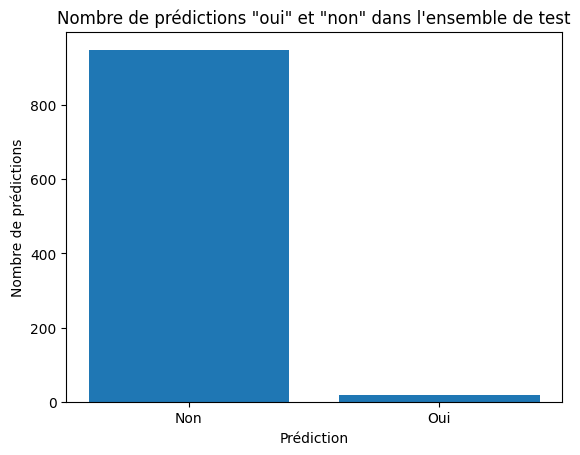

In [ ]:
import matplotlib.pyplot as plt

# Faites des prédictions sur l'ensemble de test
predictions = model.transform(test_data)

# Comptez le nombre de prédictions "oui" (1) et "non" (0)
prediction_counts = predictions.groupBy("prediction").count()

# Convertissez le résultat en DataFrame Pandas pour la visualisation
prediction_counts_pd = prediction_counts.toPandas()

# Créez un graphique à barres pour visualiser les prédictions
plt.bar(prediction_counts_pd['prediction'], prediction_counts_pd['count'])
plt.xlabel('Prédiction')
plt.ylabel('Nombre de prédictions')
plt.xticks([0, 1], ['Non', 'Oui'])
plt.title('Nombre de prédictions "oui" et "non" dans l\'ensemble de test')
plt.show()
